# Neural Half-life Regression

This is my attempt to implement a variation of Duolingo's Halflife Regression while leveraging Deep Learning. This idea was inspired by Zaidi et al.'s paper, [Adaptive Forgetting Curves for Spaced Repetition Language Learning](#https://link.springer.com/chapter/10.1007/978-3-030-52240-7_65).



$$\huge p = 2^{\frac{−∆ \cdot C}{h}}$$

- $h$ and $C$, are encoders composed of 4 layers each, representing a learner's strength and a question's complexity respectively.
- $∆$ is the time in days from the last time a student has seen some particular question or knowledge unit
- $p$ is the probability of recall, and in this model is represented as a student's correct ratio of a particular tag (after clustering).

In [12]:
%run preprocessor.ipynb

In [13]:
import tensorflow as tf

### Load and preprocess Data

In [35]:
raw = dt.fread('../riiid_data/train.csv')


train, test = time_series_split(raw, train_size=0.9, sample=0.01)
train = train.to_pandas()
test = test.to_pandas()

train_user_ids = list(train.user_id)

stats_tracker = StatsTracker()

X   = create_train_data(train, stats_tracker)
X_t = create_train_data(test, stats_tracker)

del raw
del train
del test

gc.collect()

100%|██████████| 101231/101231 [00:03<00:00, 30034.88it/s]


0

### Split Data

Split the input data into `h`, `c`, and `d`, where `h` is composed of the columns specifically related to a particular student, `c` is composed of the columns specifically related to a particular questions, and `d` is composed of the time in which the student has seen the correlating tag.

In [36]:
# variables related to a student's memory strength
h_cols = ['prior_question_elapsed_time','prior_question_had_explanation','user_correct_ratio','correct_streak','incorrect_streak',
'user_total_question_count','part_correct_ratio','time_since_last_timestamp','time_since_last_lecture','previous_question_same_bundle',
'previous_correct_and_same_bundle','user_part_correct_ratio','user_part_avg_elapsed_time','user_part_timestamp_diff','user_tag_correct_ratio',
'user_tag_avg_elapsed_time','question_history','lecture_count','questions_since_last_lec','hardest_question_correct_ratio',
'easiest_question_correct_ratio','smallest_pqet','largest_pqet','user_rating','highest_elo','lowest_elo','elo_uc']

# variables rlated to a question's complexity
c_cols = ['content_correct_ratio','tag_correct_ratio','content_rating','elo_cu','tag']

h_col_ix = [i for i,c in enumerate(analysis_columns) if c in h_cols]
c_col_ix = [i for i,c in enumerate(analysis_columns) if c in c_cols]

In [37]:
Xh_train = X[np.ix_(X[:,0]!=-1, h_col_ix)]
Xc_train = X[np.ix_(X[:,0]!=-1, c_col_ix)]
Xd_train = X[np.ix_(X[:,0]!=-1, [25])]
y_train  = X[X[:,0]!=-1, 23]


Xh_test = X_t[np.ix_(X_t[:,0]!=-1, h_col_ix)]
Xc_test = X_t[np.ix_(X_t[:,0]!=-1, c_col_ix)]
Xd_test = X_t[np.ix_(X_t[:,0]!=-1, [25])]
y_test  = X_t[X_t[:,0]!=-1, 23]

# update
y_train[y_train==-1] = 0.5
Xd_train[Xd_train==-1] = 1

y_test[y_test==-1] = 0.5
Xd_test[Xd_test==-1] = 1

In [38]:
Xh_train.shape, Xc_train.shape

((893135, 26), (893135, 4))

### Normalize 

The gradients seem to explode if we don't normalize the input data

In [39]:
# get maxes and mins
h_mmd = {}
c_mmd = {}

for i in range(Xh_train.shape[1]):
    _min = Xh_train[Xh_train[:,i]!=-1,i].min()
    _max = Xh_train[Xh_train[:,i]!=-1,i].max()
    h_mmd[i] = {'min':_min, 'max':_max}
for i in range(Xc_train.shape[1]):
    _min = Xc_train[Xc_train[:,i]!=-1,i].min()
    _max = Xc_train[Xc_train[:,i]!=-1,i].max()
    c_mmd[i] = {'min':_min, 'max':_max}

st = StatsTracker()
for i in range(Xh_train.shape[-1]):
    if i==0:
        continue
    Xh_train[:,i] = st.safe_divide(Xh_train[:,i] - h_mmd[i]['min'], h_mmd[i]['max']-h_mmd[i]['min'])
    Xh_test[:,i]  = st.safe_divide(Xh_test[:,i] - h_mmd[i]['min'], h_mmd[i]['max']-h_mmd[i]['min'])

for i in range(Xc_train.shape[-1]):
    if i==0:
        continue
    Xc_train[:,i] = st.safe_divide(Xc_train[:,i] - c_mmd[i]['min'], c_mmd[i]['max']-c_mmd[i]['min'])
    Xc_test[:,i]  = st.safe_divide(Xc_test[:,i] - c_mmd[i]['min'], c_mmd[i]['max']-c_mmd[i]['min'])

### Construct the Model

We use mean absolute error as it is inline with previous work.

In [40]:
tf.keras.backend.clear_session()

In [41]:
class HLR(tf.keras.layers.Layer):
    def __init__(self):
        super(HLR, self).__init__()
        self.sigma = tf.Variable(tf.constant(1.0e-10), trainable=False)

    def call(self, input):
        c = input[:,2:3]
        d = tf.math.divide(input[:,1:2], 24.0)
        h = input[:,0:1]
        
        p = tf.math.exp(-1.*tf.math.divide(d*c, tf.math.add(h, self.sigma)))
        return p
    
    
h_inputs = tf.keras.Input(shape=(Xh_train.shape[1],), name='h_inputs')
d_inputs = tf.keras.Input(shape=(Xd_train.shape[1],), name='d_inputs')
c_inputs = tf.keras.Input(shape=(Xc_train.shape[1],), name='c_inputs')

h = tf.keras.layers.Dense(16, activation='relu')(h_inputs)
h = tf.keras.layers.Dense(8, activation='relu')(h)
h = tf.keras.layers.Dense(4, activation='relu')(h)
h = tf.keras.layers.Dense(1, activation='sigmoid')(h)

c = tf.keras.layers.Dense(4, activation='relu')(c_inputs)
c = tf.keras.layers.Dense(2, activation='relu')(c)
c = tf.keras.layers.Dense(1, activation='sigmoid')(c)

x = tf.keras.layers.concatenate([h, d_inputs, c])
p = HLR()(x)

In [42]:
model = tf.keras.Model(
    inputs=[h_inputs, d_inputs, c_inputs], 
    outputs=p, 
    name='NHLR')

In [43]:
model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['mse',]
)

In [44]:
# model.summary()

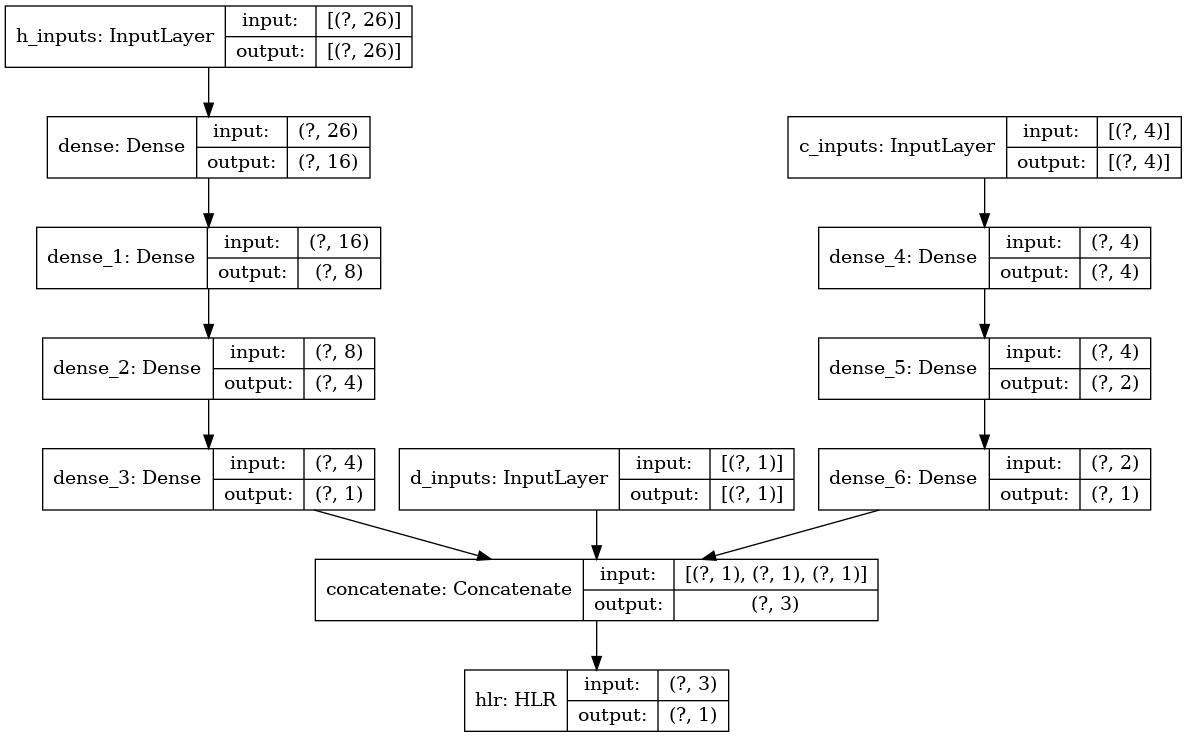

In [45]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

### Train

In [46]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(
    {'h_inputs': Xh_train, 'd_inputs': Xd_train, 'c_inputs': Xc_train},
    y_train,
    batch_size=1024,
    epochs=50,
    validation_data=([Xh_test, Xd_test, Xc_test], [y_test]),
    callbacks=[early_stop]
)

Epoch 1/50
873/873 [==============================] - 1s 829us/step - loss: 0.3377 - mse: 0.1527 - val_loss: 0.3214 - val_mse: 0.1360
Epoch 2/50
873/873 [==============================] - 1s 742us/step - loss: 0.3062 - mse: 0.1233 - val_loss: 0.2943 - val_mse: 0.1111
Epoch 3/50
873/873 [==============================] - 1s 743us/step - loss: 0.2909 - mse: 0.1099 - val_loss: 0.2939 - val_mse: 0.1112
Epoch 4/50
873/873 [==============================] - 1s 744us/step - loss: 0.2900 - mse: 0.1091 - val_loss: 0.2944 - val_mse: 0.1118
Epoch 5/50
873/873 [==============================] - 1s 744us/step - loss: 0.2893 - mse: 0.1087 - val_loss: 0.2910 - val_mse: 0.1081
Epoch 6/50
873/873 [==============================] - 1s 765us/step - loss: 0.2885 - mse: 0.1084 - val_loss: 0.2940 - val_mse: 0.1085
Epoch 7/50
873/873 [==============================] - 1s 752us/step - loss: 0.2878 - mse: 0.1082 - val_loss: 0.2906 - val_mse: 0.1085
Epoch 8/50
873/873 [==============================] - 1s 757us

In [11]:
model.save('HLR_model.model')